In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# https://www.akshare.xyz/zh_CN/latest/introduction.html
import akshare as ak
import json
import pandas as pd
import numpy as np
import rui_risk_kit as rrk
import fastquotes
import matplotlib.pyplot as plt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

## Preparing Data

In [2]:
with open('assets.json','r') as myfile:
    data=myfile.read()

assets = json.loads(data)

# 构建开放式基金以及货币基金的列表
open_mutual_fund_list = []
currency_mutual_fund_list = []

# 将开放式基金以及货币基金合并成一个dict
portfolio = {**assets['open_fund_in_porfolio'], **assets['currency_fund_in_portfolio']}

for open_fund in assets['open_fund_in_porfolio']:
    open_mutual_fund_list.append(open_fund)

for currency_fund in assets['currency_fund_in_portfolio']:
    currency_mutual_fund_list.append(currency_fund)

In [3]:
currency_fund_info_df = rrk.get_currency_fund_values(currency_mutual_fund_list)
fund_em_info_df = rrk.get_mf_values(open_mutual_fund_list, indicator='累计净值走势')

# concatenate DataFrame(currency_fund_info_df) to Dataframe(fund_em_info_df)
fund_em_info_df = pd.concat([fund_em_info_df, currency_fund_info_df], axis=1)
portfolio_fund_list = open_mutual_fund_list + currency_mutual_fund_list

# replace NA with value from previous trading day
fund_em_info_df.fillna(method ='ffill', inplace = True)
fund_em_info_df.tail()

,004342,163406,001714,003095,003096,161725,502056,005918,002963,213009,004972
净值日期,,,,,,,,,,,
2021-07-09,2.2173,7.9087,3.832,3.980,3.931,3.0324,1.6083,1.4213,1.2877,0.5618,0.6639
2021-07-10,2.2173,7.9087,3.832,3.980,3.931,3.0324,1.6083,1.4213,1.2877,0.5618,0.6629
2021-07-11,2.2173,7.9087,3.832,3.980,3.931,3.0324,1.6083,1.4213,1.2877,1.0528,0.6629
2021-07-12,2.2421,8.0190,3.923,4.137,4.086,3.0441,1.6510,1.4384,1.2841,0.5848,0.7666
2021-07-13,2.2421,8.0791,3.923,4.137,4.086,3.0441,1.6510,1.4384,1.2841,0.5312,0.6518


In [4]:
# 获取基金规模，代表基金的市值，该数据每季度更新一次
mcaps = {}
for fund in portfolio_fund_list:
    mcaps[fund] = fastquotes.fund.daily.fund_size(fund) * 100000000
mcaps

{'004342': 66000000.0,
 '163406': 26950000000.0,
 '001714': 14803000000.0,
 '003095': 19506000000.0,
 '003096': 20480000000.0,
 '161725': 49914000000.0,
 '502056': 279000000.0,
 '005918': 3744000000.0,
 '002963': 2888000000.0,
 '213009': 11915000000.0,
 '004972': 13032000000.0}

In [5]:
market_prices = ak.stock_zh_index_daily_tx(symbol="sh000300")
market_prices = market_prices.drop(market_prices.columns[[0, -1, -2, -3]], axis = 1)
market_prices.tail()

100%|██████████| 17/17 [00:12<00:00,  1.33it/s]


,close
date,
2021-07-07,5140.49
2021-07-08,5088.26
2021-07-09,5069.44
2021-07-12,5132.71
2021-07-13,5142.10


## Constructing the prior

In [6]:
S = risk_models.CovarianceShrinkage(fund_em_info_df.dropna()).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)

# NEEDS RESEARCH. Extract value from a pandas.core.series.Series
delta = list(delta)[0]

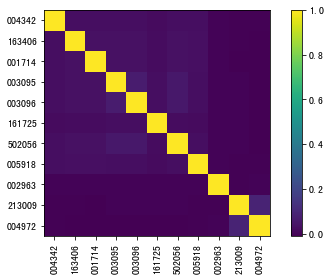

In [7]:
plotting.plot_covariance(S, plot_correlation=True);

In [8]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S, risk_free_rate=0.023)
market_prior

004342     0.047275
163406     0.279834
001714     0.174149
003095     0.236446
003096     0.244731
161725     0.471644
502056     0.064303
005918     0.080806
002963     0.044967
213009    16.706530
004972     3.032836
dtype: float64

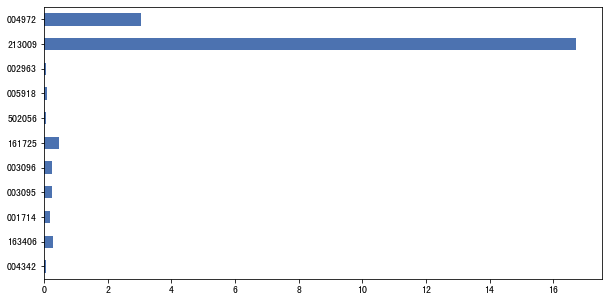

In [9]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [10]:
# You don't have to provide views on all the assets
# viewdict = {
#     "AMZN": 0.10,
#     "BAC": 0.30,
#     "COST": 0.05,
#     "DIS": 0.05,
#     "DPZ": 0.20,
#     "KO": -0.05,  # I think Coca-Cola will go down 5%
#     "MCD": 0.15,
#     "MSFT": 0.10,
#     "NAT": 0.50,  # but low confidence, which will be reflected later
#     "SBUX": 0.10
# }

viewdict = {
    "001714": 0.10,
    "002963": 0.30,
    "003095": 0.05,
    "003096": 0.20,
    "004342": -0.05,
    "004972": 0.15,
    "005918": 0.10,
    "161725": 0.12,
    "163406": 0.13,
    "213009": 0.14,
    "502056": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [11]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4,
    0.2
]

In [12]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

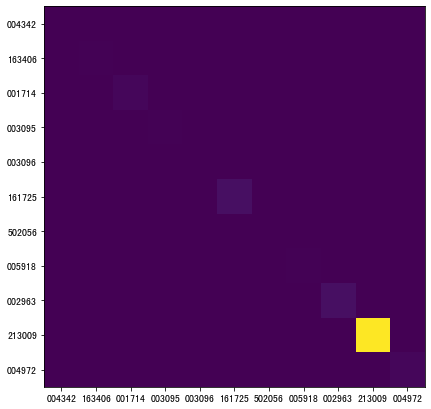

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [14]:
np.diag(bl.omega)

array([0.02895562, 0.0634997 , 0.17912409, 0.04477653, 0.01837576,
       0.40322911, 0.01846814, 0.04296886, 0.39037816, 9.96721521,
       0.17618117])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [15]:
intervals = [
    (0, 0.5),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
    (0, 0.3)
]

In [16]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.0625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [17]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [18]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

004342   -0.046070
163406    0.228320
001714    0.130384
003095    0.090874
003096    0.200999
161725    0.123056
502056    0.076311
005918    0.097327
002963    0.204769
213009    0.193905
004972    0.156161
dtype: float64

We can visualise how this compares to the prior and our views:

In [19]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T

rets_df

,Prior,Posterior,Views
004342,0.047275,-0.046070,-0.05
163406,0.279834,0.228320,0.13
001714,0.174149,0.130384,0.10
003095,0.236446,0.090874,0.05
003096,0.244731,0.200999,0.20
161725,0.471644,0.123056,0.12
502056,0.064303,0.076311,0.10
005918,0.080806,0.097327,0.10
002963,0.044967,0.204769,0.30
213009,16.706530,0.193905,0.14


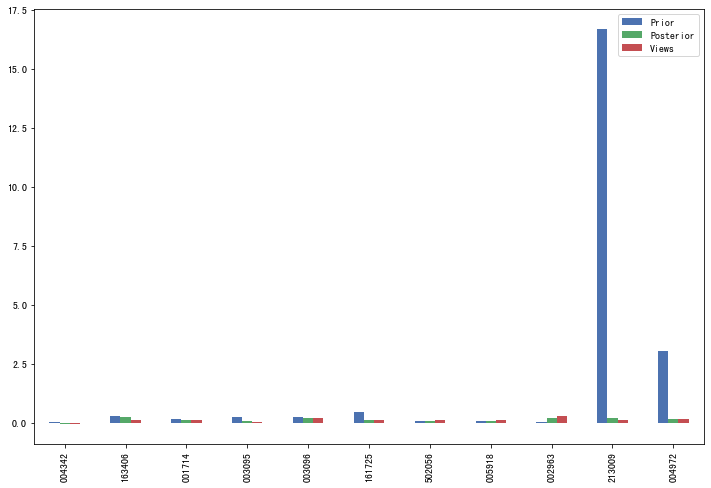

In [20]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

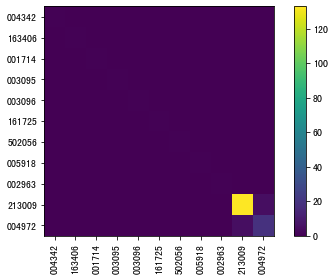

In [21]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [22]:
from pypfopt import EfficientFrontier, objective_functions

In [23]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/opt/anaconda3/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:252: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('004342', 0.0),
             ('163406', 0.21178),
             ('001714', 0.10691),
             ('003095', 0.06014),
             ('003096', 0.18076),
             ('161725', 0.1039),
             ('502056', 0.04636),
             ('005918', 0.07404),
             ('002963', 0.19934),
             ('213009', 0.00234),
             ('004972', 0.01444)])

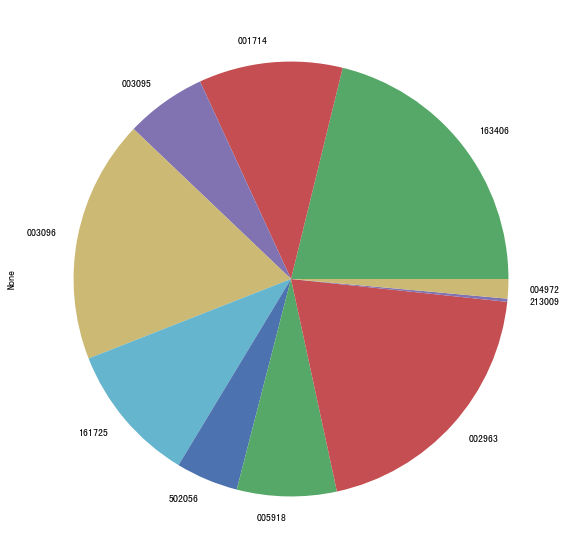

In [24]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [25]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, fund_em_info_df.iloc[-2], total_portfolio_value=300000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

NameError: Solver GLPK_MI is not installed. 

In [27]:
total_portfolio_value = 300000

for asset, pct in weights.items():
    print(asset, pct * total_portfolio_value)

004342 0.0
163406 63534.0
001714 32073.0
003095 18042.0
003096 54228.0
161725 31170.000000000004
502056 13908.0
005918 22212.0
002963 59802.0
213009 702.0
004972 4332.0
